### Imports

In [1]:
import os
from os.path import isfile
from PIL import Image, ImageFile
import tqdm
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

from albumentations import *
import cv2
import pretrainedmodels

from sklearn.model_selection import train_test_split
import sklearn.metrics

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
plt.gray()

<Figure size 432x288 with 0 Axes>

In [2]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets

def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss()
    # weighted to reflect competition metric
    return 1.5 * (lam * criterion(preds1, targets1.long()) + (1 - lam) * criterion(preds1, targets2.long())) + (lam * criterion(preds2, targets3.long()) + (1 - lam) * criterion(preds2, targets4.long())) + (lam * criterion(preds3, targets5.long()) + (1 - lam) * criterion(preds3, targets6.long()))

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss()
    # weighted to reflect competition metric
    return 1.5 * (lam * criterion(preds1, targets1.long()) + (1 - lam) * criterion(preds1, targets2.long())) + (lam * criterion(preds2, targets3.long()) + (1 - lam) * criterion(preds2, targets4.long())) + (lam * criterion(preds3, targets5.long()) + (1 - lam) * criterion(preds3, targets6.long()))

### Dataset and DataLoader

In [3]:
class bengali(Dataset):
    """
    Dataset for bengali characters. A train test split is performed within the initialization
    to split the dataset into a training and validation set.
    """
    
    def __init__(self, root, subset='train', transform=None):
        self.root = os.path.expanduser(root)
        self.subset = subset
        self.transform = transform
        self.data_path = []
        self.df_og_labels = pd.read_csv('train.csv')
        
        train_indices, val_indices = train_test_split(self.df_og_labels.index.values, test_size=0.2, random_state=42)
        self.df_train_labels = self.df_og_labels.loc[train_indices].sort_index().copy()
        self.df_val_labels = self.df_og_labels.loc[val_indices].sort_index().copy()
        
        def load_images(path):
            """
            returns all the sorted image paths.

            :param path: path to where the images are stored
            :return: array with all the paths to the images
            """
            ls_image_ids = [f[:-4] for f in os.listdir(path) if isfile(os.path.join(path, f))]
            df_image_ids = pd.DataFrame({'image_id':ls_image_ids})
            
            if self.subset == 'train':
                df_filt = pd.merge(df_image_ids, 
                                   self.df_train_labels, 
                                   on='image_id')
            elif self.subset == 'val':
                df_filt = pd.merge(df_image_ids, 
                                   self.df_val_labels, 
                                   on='image_id')
            else:
                print('Subset must be one of "train" or "val"!')
            
            df_filt['image_paths'] = df_filt['image_id'].apply(lambda x: os.path.join(path, x+'.png'))
            images_dir = list(df_filt['image_paths'])
            
            # sort using image number as a key so the paths are sorted in the same order as the train.csv
            images_dir.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

            return images_dir

        self.data_path = load_images(self.root + '/train')
        
        if self.subset == 'train':
            self.df_labels = self.df_train_labels.copy()
        elif self.subset == 'val':
            self.df_labels = self.df_val_labels.copy()
            
    def __getitem__(self, idx):
        img = np.array(Image.open(self.data_path[idx]), dtype=np.uint8)
        arr_label = self.df_labels.iloc[idx, 1:4].values.astype(int) # grapheme, vowel, consonant label

        if self.transform is not None:
            img = self.transform(image=img)
            img = transforms.Compose([transforms.ToTensor()])(img['image'])

        return img, arr_label
    
    def __len__(self):
        return len(self.data_path)

In [4]:
new_size = 224
batch_size = 64

train_dataset = bengali(root='.',
                        subset='train',
                        transform=Compose([Resize(new_size,new_size),
                                           ShiftScaleRotate(rotate_limit=15),
                                           Cutout(num_holes=1, max_h_size=100, max_w_size=100)]))

trainacc_dataset = bengali(root='.',
                           subset='train',
                           transform=Compose([Resize(new_size,new_size)]))

val_dataset = bengali(root='.',
                      subset='val',
                      transform=Compose([Resize(new_size,new_size)]))
trainacc_dataset, throwaway = torch.utils.data.random_split(trainacc_dataset, (len(val_dataset), len(trainacc_dataset)-len(val_dataset)))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

trainacc_loader = DataLoader(dataset=trainacc_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=4)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

In [5]:
print('Train dataset len:', len(train_dataset))
print('Train accuracy dataset len:', len(trainacc_dataset))
print('Validation dataset len:', len(val_dataset))

Train dataset len: 160672
Train accuracy dataset len: 40168
Validation dataset len: 40168


Inspect images to make sure the augmentations look reasonable.

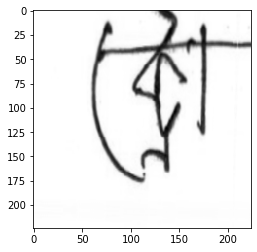

In [6]:
plt.imshow(train_dataset[0][0].squeeze())

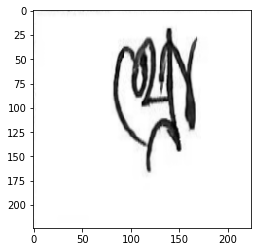

In [7]:
plt.imshow(val_dataset[0][0].squeeze())

### Model

In [8]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
       
    def forward(self, x):
        return x

class MultiHeadResNext(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.conv_3ch = nn.Conv2d(1, 3, kernel_size=1)
        self.grapheme1 = nn.Linear(in_features=2048, out_features=1024, bias=True)
        self.grapheme2 = nn.Linear(in_features=1024, out_features=168, bias=True)
        self.vowel = nn.Linear(in_features=2048, out_features=11, bias=True)
        self.consonant = nn.Linear(in_features=2048, out_features=7, bias=True)
    
    def forward(self, x):
        x = self.conv_3ch(x)
        x = self.model(x)
        grapheme_output = self.grapheme1(x)
        grapheme_output = self.grapheme2(grapheme_output)
        vowel_output = self.vowel(x)
        consonant_output = self.consonant(x)

        return grapheme_output, vowel_output, consonant_output

In [9]:
print(pretrainedmodels.pretrained_settings['se_resnet50'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [10]:
model = pretrainedmodels.__dict__['se_resnet50'](pretrained='imagenet')
model.last_linear = Identity()
net = MultiHeadResNext(model=model)

In [11]:
os.environ['CUDA_VISIBLE_DEVICES']='4'
device = torch.device('cuda')
net.to(device)

MultiHeadResNext(
  (model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace

In [12]:
def train(model, optimizer, loader):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch in tqdm.tqdm(loader, desc='Train Batch'):
        # Get image and class labels for the batch
        image = batch[0].to(device)
        grapheme = batch[1][:,0].to(device)
        vowel = batch[1][:,1].to(device)
        consonant = batch[1][:,2].to(device)
        
        x = np.random.uniform()
        if x < 0.4: # Mixup
            image, targets = mixup(image, grapheme, vowel, consonant, alpha=1)
        if x > 0.6: # Cutmix
            image, targets = cutmix(image, grapheme, vowel, consonant, alpha=1)
        
        # Calculate Loss and Update Gradients, for each class
        # Get Predictions
        grapheme_pred, vowel_pred, consonant_pred = model(image)
        
        if x < 0.3: # Mixup Loss
            loss = mixup_criterion(grapheme_pred, vowel_pred, consonant_pred, targets)
        if x > 0.7: # Cutmix Loss
            loss = cutmix_criterion(grapheme_pred, vowel_pred, consonant_pred, targets)
        else: # Regular Loss
            loss = ((1.5 * criterion(input=grapheme_pred, target=grapheme.long())) +
                    criterion(input=vowel_pred, target=vowel.long()) + 
                    criterion(input=consonant_pred, target=consonant.long()))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    return loss.item()
        
        
def validate(model, loader):
    model.eval()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    r_g = 0
    r_v = 0
    r_c = 0
    count_grapheme = 0
    count_vowel = 0
    count_consonant = 0
    for batch in tqdm.tqdm(loader, desc='Validate Batch'): 
        # Get image and class labels for the batch
        image = batch[0].to(device)
        grapheme = batch[1][:,0].to(device)
        vowel = batch[1][:,1].to(device)
        consonant = batch[1][:,2].to(device)

        #Get Predictions
        grapheme_pred, vowel_pred, consonant_pred = model(image)
        loss = ((1.5 * criterion(input=grapheme_pred, target=grapheme.long())) +
            criterion(input=vowel_pred, target=vowel.long()) + 
            criterion(input=consonant_pred, target=consonant.long()))
        total_loss += loss.item()

        grapheme_pred = torch.argmax(grapheme_pred, dim=1)
        vowel_pred = torch.argmax(vowel_pred, dim=1)
        consonant_pred = torch.argmax(consonant_pred, dim=1)
        
        count_grapheme += (grapheme == grapheme_pred).sum().item()
        count_vowel += (vowel == vowel_pred).sum().item()
        count_consonant += (consonant == consonant_pred).sum().item()
        r_g += sklearn.metrics.recall_score(grapheme.cpu(), grapheme_pred.cpu(), average='macro')
        r_v += sklearn.metrics.recall_score(vowel.cpu(), vowel_pred.cpu(), average='macro')
        r_c += sklearn.metrics.recall_score(consonant.cpu(), consonant_pred.cpu(), average='macro')

    r_g /= len(loader)
    r_v /= len(loader)
    r_c /= len(loader)
    scores = [r_g, r_c, r_v]
    final_score = np.average(scores, weights=[2,1,1])

    return count_grapheme, count_vowel, count_consonant, final_score, total_loss / len(loader)

In [13]:
optimizer = optim.Adam(net.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 patience=5, 
                                                 threshold=1e-2,
                                                 verbose=True, 
                                                 factor=0.5)

Validate Batch:   0%|          | 0/628 [00:00<?, ?it/s]/home/akjha/anaconda3/envs/ucsf/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
Validate Batch: 100%|██████████| 628/628 [00:50<00:00, 12.50it/s]


Got 34644 / 40168 Graphemes Correct, 38299 / 40168 Vowels Correct, and 38009 / 40168 Consonants Correct
Epoch: 1, Recall: 0.844243584778506


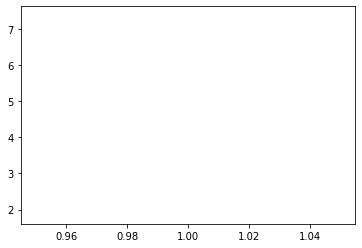

/home/akjha/anaconda3/envs/ucsf/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MultiHeadResNext. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akjha/anaconda3/envs/ucsf/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SENet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akjha/anaconda3/envs/ucsf/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akjha/anaconda3/envs/ucsf/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness u

saving


/home/akjha/anaconda3/envs/ucsf/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akjha/anaconda3/envs/ucsf/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akjha/anaconda3/envs/ucsf/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SEResNetBottleneck. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akjha/anaconda3/envs/ucsf/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SEModule. It won't be checked for correctness

Got 36576 / 40168 Graphemes Correct, 38623 / 40168 Vowels Correct, and 37446 / 40168 Consonants Correct
Epoch: 2, Recall: 0.8759220865876726


saving



In [14]:
train_loss = []
val_loss = []
x_axis = []
best_metric = -np.inf

for t in tqdm.tnrange(2, desc='Epochs'):
    train_loss.append(train(net, optimizer, train_loader))
    cg, cv, cc, metric, vl = validate(net, val_loader)
    scheduler.step(vl)
    val_loss.append(vl)
    print(f'Got {cg} / 40168 Graphemes Correct, {cv} / 40168 Vowels Correct, and {cc} / 40168 Consonants Correct')
    x_axis.append(t+1)
    print(f'Epoch: {t+1}, Recall: {metric}')
    plt.plot(x_axis, train_loss, color='blue')
    plt.plot(x_axis, val_loss, color='red')
    plt.show()
    plt.close()
    if metric > best_metric:
        print('saving')
        torch.save(net, 'saved_models/seresnext50_cutmix.pt')
        best_metric = metric